<h1 align='center'>Image Super-Resolution Using Deep Convolutional Networks</center>


This is the implementation of SRCNN.

More details can be found [here](http://mmlab.ie.cuhk.edu.hk/projects/SRCNN.html)

# Load library 

In [2]:
from keras.datasets import mnist
from keras.layers import Reshape,Dense
import numpy as np
from keras.layers import UpSampling2D,MaxPool2D,Conv2D,Activation,Dropout,BatchNormalization
from keras.models import Sequential
import matplotlib.pyplot as plt
from scipy.misc import imresize
from scipy import ndimage as nd
import myplot
from skimage.measure import compare_psnr,compare_ssim
from tqdm import tqdm_notebook as tqdm
from keras.preprocessing.image import ImageDataGenerator
from skimage.color import ycbcr2rgb,rgb2ycbcr
from scipy.misc import imread
from keras.models import load_model
# from skimage.color import rgb2 

def psnr(Original_test,test_image,interpolation):
    psnr_value = []
    for O_image,SR_image in zip(Original_test,test_image):
        imrecov = imresize(SR_image,size=(28,28),interp=interpolation)
        psnr_value.append(compare_psnr(O_image,imrecov.astype('float64')))
        return np.array(psnr_value).mean() 

# Load data 

In [3]:
down=np.load('BSD100-SRF_4.npz')
LR_images = down['LR']
HR_images = down['HR']
LR_images=LR_images.astype('uint8')
HR_images=HR_images.astype('uint8')

# Visualise HR and LR in RBG

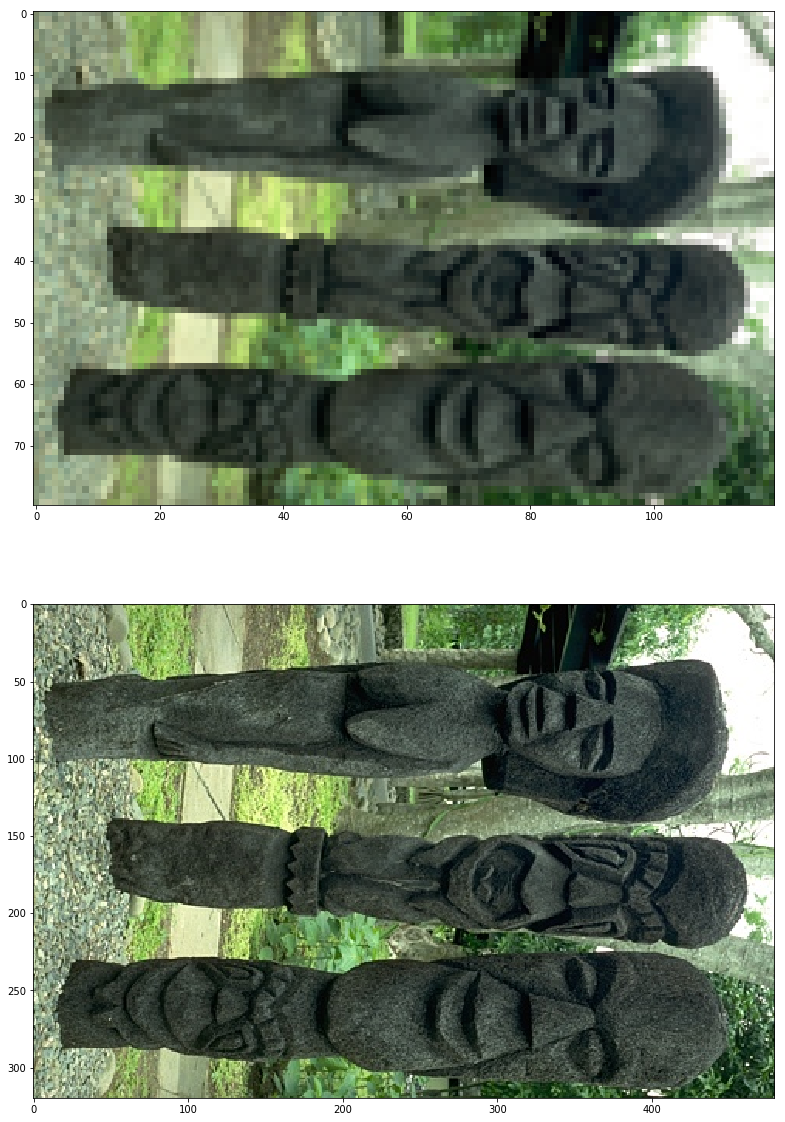

In [4]:
plt.figure(figsize=(30,20))
plt.subplot(211)
plt.imshow((LR_images[0]))
plt.subplot(212)
plt.imshow((HR_images[0]))
plt.show()

In [5]:
#Original_image = np.reshape(LR_images,(LR_images.shape[0],LR_images.shape[1],LR_images.shape[2],1))
print 'shape of original image is %d x %d  x%d  x%d ' %HR_images.shape
#LR_mnist = np.reshape(LR_mnist,(LR_mnist.shape[0],LR_mnist.shape[1],LR_mnist.shape[2],1))
print 'shape of downsample image is  %d x %d  x%d  x%d  ' %LR_images.shape 

shape of original image is 100 x 320  x480  x3 
shape of downsample image is  100 x 80  x120  x3  


# Bicubic interplation 

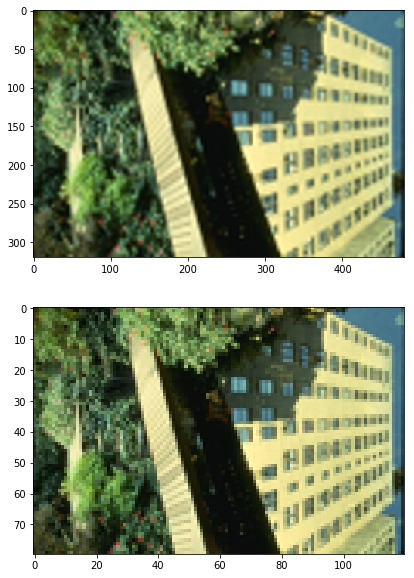

In [15]:
temp_bicubic= []
for index in tqdm(range(len(LR_images))):
    temp_bicubic.append(imresize(LR_images[index],size=4.0,interp='bicubic'))
bicubic_LR =np.array(temp_bicubic)
# bicubic_mnist = np.reshape(bicubic_mnist,(bicubic_mnist.shape[0],bicubic_mnist.shape[1],bicubic_mnist.shape[2],1))
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.imshow(bicubic_LR[20])
plt.subplot(212)
plt.imshow(LR_images[20])
plt.show()

## Convert RGB to YCbCr 

In [16]:
value_of_L =[]
value_of_H = []

for L_image,H_image in tqdm(zip(bicubic_LR,HR_images)):
    value_of_L.append(rgb2ycbcr(L_image))
    value_of_H.append(rgb2ycbcr(H_image))

HR_ycbcr= np.stack(value_of_H)
LR_ycbcr= np.stack(value_of_L)

# Visualise single channel in YCBCR

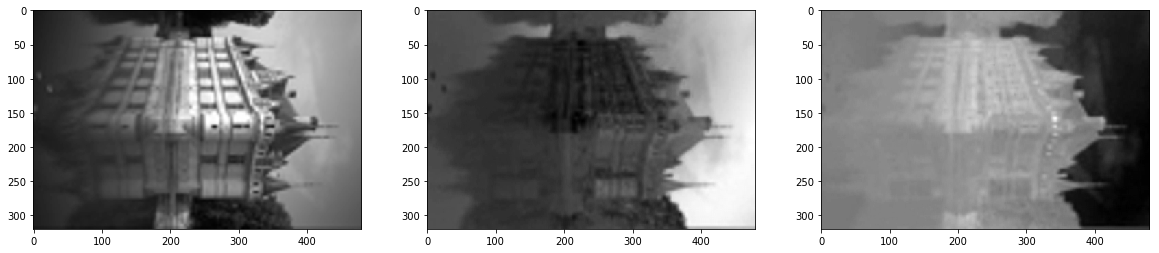

In [17]:
plt.figure(figsize=(20,20))

plt.subplot(131)
plt.imshow(LR_ycbcr[2,:,:,0],cmap='gray')
plt.subplot(132)
plt.imshow(LR_ycbcr[2,:,:,1],cmap='gray')
plt.subplot(133)
plt.imshow(LR_ycbcr[2,:,:,2],cmap='gray')
plt.show()

# Traditional method of recover image from low resolution 

imresize support a lot of image Interpolation methods there I examed 5 of them. 
They are:  
- nearest 
- lanczors
- bilinear 
- cubic 
- bicubic 

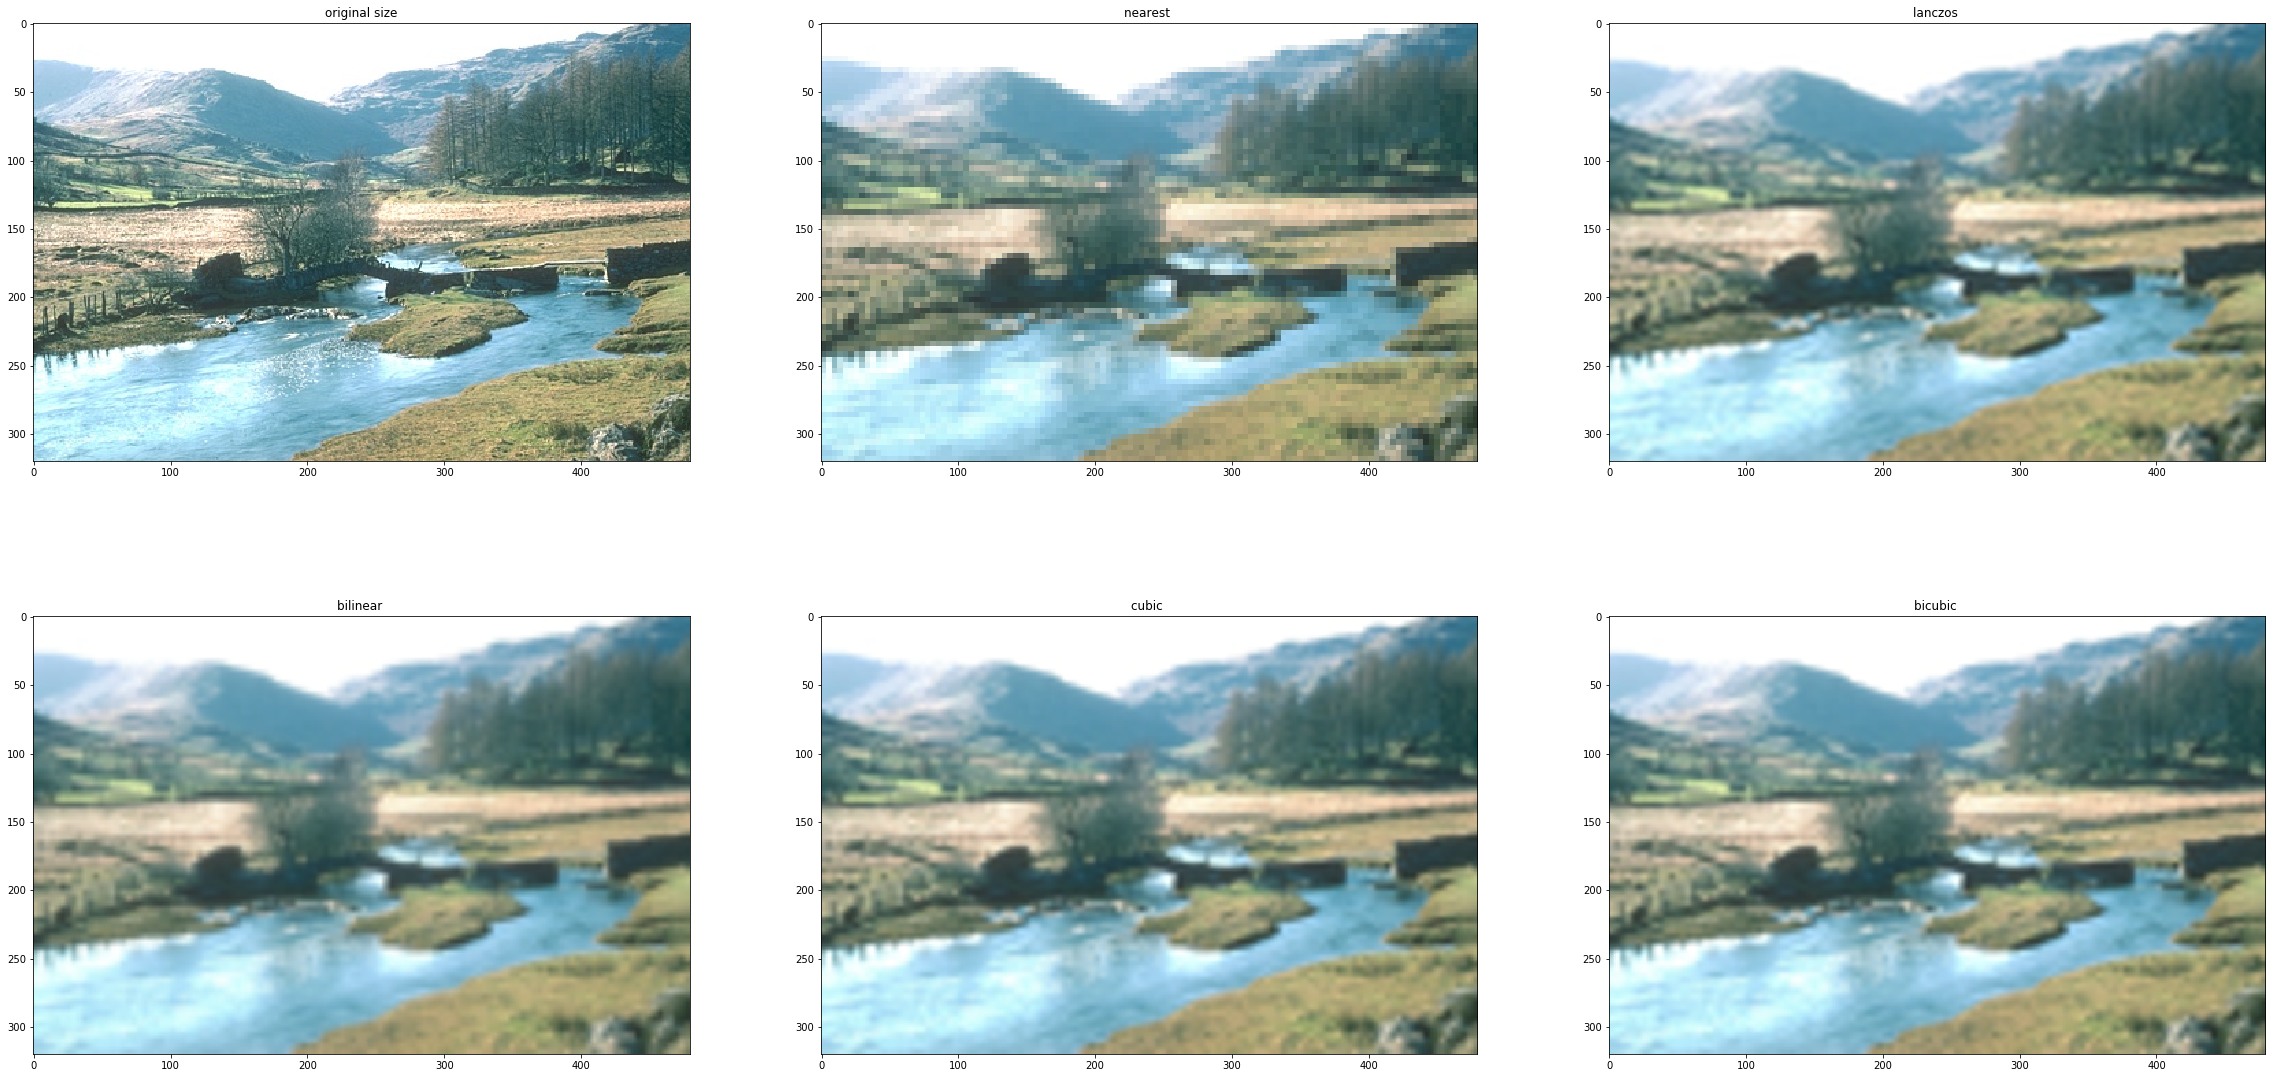

In [18]:
#bicubic_mnist = np.reshape(LR_images,(LR_mnist.shape[0],LR_mnist.shape[1],LR_mnist.shape[2]))
image_index=50
#Img_HR = ycbcr2rgb(HR_images[image_index])
#Img_LR = ycbcr2rgb(HR_images[image_index])
plt.figure(figsize=(40,20))
myplot.plot_comparison(O_image=ycbcr2rgb(value_of_H[image_index]),down_image=LR_images[image_index])

# The input is the bicubic-low-resolution image , the output is the original image

Before generate the model. It is very important to normalise the image . 
The SRCNN is only operated in Y channel. Only Y channel is normalised and the CNN is take 1 color channel is input.
The original value of image is between 0 and 255, I will make it between -1 and 1. 


In [19]:
LR_Y_channel = (LR_ycbcr[:,:,:,0]-127.5)/128
HR_Y_channel =(HR_ycbcr[:,:,:,0]-127.5)/128
# bicubic_LR=(bicubic_LR-127.5)/128
LR_Y_channel = np.reshape(LR_Y_channel,(LR_Y_channel.shape[0],LR_Y_channel.shape[1],LR_Y_channel.shape[2],1))

HR_Y_channel = np.reshape(HR_Y_channel,(HR_Y_channel.shape[0],HR_Y_channel.shape[1],HR_Y_channel.shape[2],1))
print 'Max of LR_mnist is %f, Min of LR_mnist is %f' %(LR_Y_channel.max() ,LR_Y_channel.min() )
print 'Max of Original_image is %f, Min of Original_image is %f' %(LR_Y_channel.max() ,LR_Y_channel.min() )


Max of LR_mnist is 0.839844, Min of LR_mnist is -0.871094
Max of Original_image is 0.839844, Min of Original_image is -0.871094


In [20]:
G=Sequential()
G.add(Conv2D(64,(9,9),padding='same',input_shape=(None,None,1)))
#G.add(Conv2D(16,(5,5),padding='same'))
#G.add(Dropout(0.9))
G.add(Activation('relu')) 
G.add(Conv2D(32,(1,1),padding='same'))
G.add(Activation('relu'))
# G.add(BatchNormalization())
G.add(Conv2D(1,(5,5),padding='same'))
#G.add(Activation('sigmoid'))
G.summary()

G.compile(loss='mse',optimizer='adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, None, None, 64)    5248      
_________________________________________________________________
activation_3 (Activation)    (None, None, None, 64)    0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, None, None, 32)    2080      
_________________________________________________________________
activation_4 (Activation)    (None, None, None, 32)    0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, None, None, 1)     801       
Total params: 8,129
Trainable params: 8,129
Non-trainable params: 0
_________________________________________________________________


In [21]:
G.fit(x=LR_Y_channel,y=HR_Y_channel,batch_size=8,epochs=20)

Epoch 1/20
100/100 [==============================] - 7s - loss: 0.0564      
Epoch 2/20
100/100 [==============================] - 6s - loss: 0.0230     

In [192]:
G.save('SRCNN_ycbcr_SR_4.h5')

# Benchmark 

In [3]:
G=load_model('SRCNN_ycbcr_SR_4.h5')

In [4]:
def super_resolution(image,model):
    # image is in RGB channel. after Bicubic ! 
    Image_to_test = rgb2ycbcr(image)
    Image_to_test_y_channel = Image_to_test[:,:,0]
    Image_to_test_y_channel =(Image_to_test_y_channel-127.5)/128
    Image_to_test_y_channel = np.reshape(Image_to_test_y_channel,(1,Image_to_test_y_channel.shape[0],Image_to_test_y_channel.shape[1],1))
    Image_to_test_y_channel_pred= G.predict(x=Image_to_test_y_channel)
    Image_to_test_y_channel_pred = np.reshape(Image_to_test_y_channel_pred,(Image_to_test_y_channel_pred.shape[1],Image_to_test_y_channel_pred.shape[2]))
    Image_to_test_y_channel_pred=(Image_to_test_y_channel_pred*128)+127.5
    Image_to_test[:,:,0]=Image_to_test_y_channel_pred
    exam_image_RGB = ycbcr2rgb(Image_to_test)
    exam_image_RGB[exam_image_RGB>1]=1
    exam_image_RGB[exam_image_RGB<0]=0
    exam_image_RGB *=255
    exam_image_RGB=exam_image_RGB.astype('uint8')
    return exam_image_RGB

In [5]:
plt.imshow(super_resolution(bicubic_LR[30],G))
plt.show()

NameError: name 'bicubic_LR' is not defined

In [198]:
for index in tqdm(range(100)):
    plt.figure(figsize=(20,30))
    plt.subplot(311)
    plt.title('BICUBIC')
    plt.imshow(ycbcr2rgb(LR_ycbcr[index]))

    plt.subplot(312)
    plt.title('SRCNN-YCBCR')
    plt.imshow(super_resolution(bicubic_LR[index],G))

    plt.subplot(313)
    plt.title('HR')
    plt.imshow(HR_images[index])

    path = './SRCNN_result/BSD100_SRF_4_YCBCR_'+str(index)
    print path
    plt.savefig(path)
    plt.close()

./SRCNN_result/BSD100_SRF_4_YCBCR_0
./SRCNN_result/BSD100_SRF_4_YCBCR_1
./SRCNN_result/BSD100_SRF_4_YCBCR_2
./SRCNN_result/BSD100_SRF_4_YCBCR_3
./SRCNN_result/BSD100_SRF_4_YCBCR_4
./SRCNN_result/BSD100_SRF_4_YCBCR_5
./SRCNN_result/BSD100_SRF_4_YCBCR_6
./SRCNN_result/BSD100_SRF_4_YCBCR_7
./SRCNN_result/BSD100_SRF_4_YCBCR_8
./SRCNN_result/BSD100_SRF_4_YCBCR_9
./SRCNN_result/BSD100_SRF_4_YCBCR_10
./SRCNN_result/BSD100_SRF_4_YCBCR_11
./SRCNN_result/BSD100_SRF_4_YCBCR_12
./SRCNN_result/BSD100_SRF_4_YCBCR_13
./SRCNN_result/BSD100_SRF_4_YCBCR_14
./SRCNN_result/BSD100_SRF_4_YCBCR_15
./SRCNN_result/BSD100_SRF_4_YCBCR_16
./SRCNN_result/BSD100_SRF_4_YCBCR_17
./SRCNN_result/BSD100_SRF_4_YCBCR_18
./SRCNN_result/BSD100_SRF_4_YCBCR_19
./SRCNN_result/BSD100_SRF_4_YCBCR_20
./SRCNN_result/BSD100_SRF_4_YCBCR_21
./SRCNN_result/BSD100_SRF_4_YCBCR_22
./SRCNN_result/BSD100_SRF_4_YCBCR_23
./SRCNN_result/BSD100_SRF_4_YCBCR_24
./SRCNN_result/BSD100_SRF_4_YCBCR_25
./SRCNN_result/BSD100_SRF_4_YCBCR_26
./SRCNN_res

In [199]:
compare_psnr(HR_images[index],exam_image_RGB.astype('uint8'))

7.4372274676874746

In [200]:
compare_psnr(HR_images[index],ycbcr2rgb(LR_ycbcr[index]).astype('uint8'))

4.1437256540196614

In [6]:
for index in tqdm(range(1,15)):
    if index <10:
        mypath = './data/Set5/image_SRF_4/img_00'+str(index) +'_SRF_4_HR.png'
        value_truth=imread(mypath)
        mypath = './data/Set5/image_SRF_4/img_00'+str(index) +'_SRF_4_LR.png'
        value_pred=imread(mypath)
    else: 
        mypath = './data/Set5/image_SRF_4/img_0'+str(index) +'_SRF_4_HR.png'
        value_truth=imread(mypath)
        mypath = './data/Set5/image_SRF_4/img_0'+str(index) +'_SRF_4_LR.png'
        value_pred=imread(mypath)
    if len(value_pred.shape) ==2:
        continue
    plt.figure(figsize=(20,30))
    plt.subplot(311)
    plt.title('BICUBIC')

    value_pred_bi=imresize(arr=value_pred,size=4.0,interp='bicubic')

    plt.imshow(value_pred_bi)
    plt.subplot(312)
    plt.title('SRCNN-YCBCR')
    plt.imshow(super_resolution(value_pred_bi,G))
    plt.subplot(313)
    plt.title('HR')
    plt.imshow(value_truth)
    #plt.show()
#mypath = './data/Set14/image_SRF_4/img_001_SRF_4_HR.png'
#value_truth=imread(mypath)
#mypath = './data/Set14/image_SRF_4/img_001_SRF_4_LR.png'
#value_pred=imread(mypath)
    path = './SRCNN_result/Set5_SRF_4_YCBCR_'+str(index)
    print path
    plt.savefig(path)
    plt.close()


ResourceExhaustedError: OOM when allocating tensor with shape[64,1,9,9]
	 [[Node: conv2d_4/convolution = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](_recv_conv2d_4_input_0/_103, conv2d_4/kernel/read)]]
	 [[Node: conv2d_6/BiasAdd/_105 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_33_conv2d_6/BiasAdd", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op u'conv2d_4/convolution', defined at:
  File "/home/hongbin/anaconda2/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/hongbin/anaconda2/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/hongbin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/hongbin/anaconda2/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/hongbin/anaconda2/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/hongbin/anaconda2/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/hongbin/anaconda2/lib/python2.7/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/hongbin/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/hongbin/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/hongbin/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/hongbin/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/hongbin/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/hongbin/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/hongbin/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/hongbin/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/home/hongbin/anaconda2/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/hongbin/anaconda2/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/hongbin/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/hongbin/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/hongbin/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-3-3ac680813dcf>", line 1, in <module>
    G=load_model('SRCNN_ycbcr_SR_4.h5')
  File "/home/hongbin/anaconda2/lib/python2.7/site-packages/keras/models.py", line 240, in load_model
    model = model_from_config(model_config, custom_objects=custom_objects)
  File "/home/hongbin/anaconda2/lib/python2.7/site-packages/keras/models.py", line 304, in model_from_config
    return layer_module.deserialize(config, custom_objects=custom_objects)
  File "/home/hongbin/anaconda2/lib/python2.7/site-packages/keras/layers/__init__.py", line 54, in deserialize
    printable_module_name='layer')
  File "/home/hongbin/anaconda2/lib/python2.7/site-packages/keras/utils/generic_utils.py", line 140, in deserialize_keras_object
    list(custom_objects.items())))
  File "/home/hongbin/anaconda2/lib/python2.7/site-packages/keras/models.py", line 1203, in from_config
    model.add(layer)
  File "/home/hongbin/anaconda2/lib/python2.7/site-packages/keras/models.py", line 433, in add
    layer(x)
  File "/home/hongbin/anaconda2/lib/python2.7/site-packages/keras/engine/topology.py", line 585, in __call__
    output = self.call(inputs, **kwargs)
  File "/home/hongbin/anaconda2/lib/python2.7/site-packages/keras/layers/convolutional.py", line 164, in call
    dilation_rate=self.dilation_rate)
  File "/home/hongbin/anaconda2/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py", line 3095, in conv2d
    data_format='NHWC')
  File "/home/hongbin/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/nn_ops.py", line 661, in convolution
    op=op)
  File "/home/hongbin/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/nn_ops.py", line 331, in with_space_to_batch
    return op(input, num_spatial_dims, padding)
  File "/home/hongbin/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/nn_ops.py", line 653, in op
    name=name)
  File "/home/hongbin/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/nn_ops.py", line 129, in _non_atrous_convolution
    name=name)
  File "/home/hongbin/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 403, in conv2d
    data_format=data_format, name=name)
  File "/home/hongbin/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 768, in apply_op
    op_def=op_def)
  File "/home/hongbin/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2336, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/hongbin/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1228, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[64,1,9,9]
	 [[Node: conv2d_4/convolution = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](_recv_conv2d_4_input_0/_103, conv2d_4/kernel/read)]]
	 [[Node: conv2d_6/BiasAdd/_105 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_33_conv2d_6/BiasAdd", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [231]:
mypath = './data/Set5/image_SRF_4/img_001_SRF_4_HR.png'
value_truth=imread(mypath)
mypath = './data/Set5/image_SRF_4/img_001_SRF_4_LR.png'
value_pred=imread(mypath)
value_pred_bi=imresize(arr=value_pred,size=4.0,interp='bicubic')
input_YCBCR = rgb2ycbcr(value_pred_bi)
input_Y = input_YCBCR[:,:,0]
input_Y = (input_Y-127.5)/128
input_Y=np.reshape(input_Y,(1,input_Y.shape[0],input_Y.shape[1],1))

predict_SR= G.predict(x=input_Y)
predict_SR=predict_SR*128+127.5

In [232]:
input_Y.shape

(1, 512, 512, 1)

In [233]:

predict_SR=predict_SR.astype('uint8')
input_YCBCR[:,:,0]=predict_SR[0,:,:,0]

input_RGB =ycbcr2rgb(input_YCBCR)
input_RGB*=255
input_RGB[input_RGB>255]=255
input_RGB[input_RGB<0]=0

In [234]:
input_RGB.max()

255.0

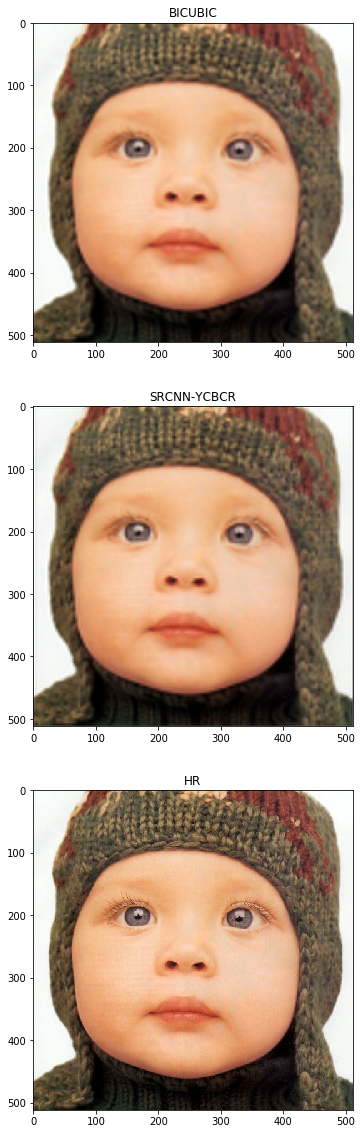

In [235]:
plt.figure(figsize=(20,20))

plt.subplot(311)
plt.title('BICUBIC')
plt.imshow(value_pred_bi)

plt.subplot(312)
plt.title('SRCNN-YCBCR')
plt.imshow(input_RGB.astype('uint8'))



plt.subplot(313)
plt.title('HR')
plt.imshow(value_truth)


plt.savefig('SET5_SRF_4_YCBCR_04')
plt.show()
plt.close()

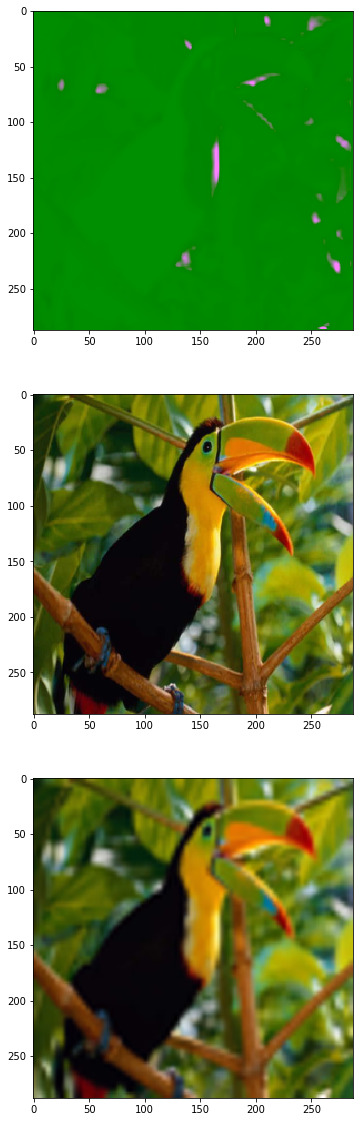

In [149]:
mypath = './data/Set5/image_SRF_4/img_002_SRF_4_HR.png'
value_truth=imread(mypath)
mypath = './data/Set5/image_SRF_4/img_002_SRF_4_LR.png'
value_pred=imread(mypath)
value_pred_bi=imresize(arr=value_pred,size=4.0,interp='bicubic')
value_pred=(value_pred_bi-127.5)/128
value_pred=np.reshape(value_pred,(1,value_pred.shape[0],value_pred.shape[1],value_pred.shape[2]))

value_pred=rgb2ycbcr(value_pred)
input_value = np.reshape(value_pred[:,:,:,0],(1,value_pred.shape[1],value_pred.shape[2],1))


predict_SR= G.predict(x=input_value)
#predict_SR=predict_SR*128+127.5
#predict_SR[predict_SR>255]=255
#predict_SR[predict_SR<0]=0

predict_SR.max()
#predict_SR=predict_SR.astype('uint8')

predict_SR=np.reshape(predict_SR,(predict_SR.shape[1],predict_SR.shape[2],1))
value_pred[0,:,:,:]=predict_SR

value_pred=np.reshape(value_pred,(value_pred.shape[1],value_pred.shape[2],3))
value_pred=ycbcr2rgb(value_pred)
value_pred=value_pred*255
value_pred[value_pred>255]=255
value_pred[value_pred<0]=0


plt.figure(figsize=(20,20))
plt.subplot(311)
plt.imshow(value_pred.astype('uint8'))
plt.subplot(312)
plt.imshow(value_truth.astype('uint8'))
plt.subplot(313)
plt.imshow(value_pred_bi.astype('uint8'))

plt.show()

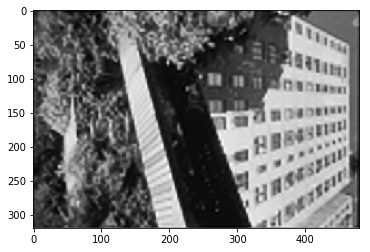

In [126]:
index = 20
Image_to_test = LR_ycbcr[index].copy()
Image_to_test_y_channel = Image_to_test[:,:,0]
Image_to_test_y_channel =(Image_to_test_y_channel-127.5)/128
Image_to_test_y_channel = np.reshape(Image_to_test_y_channel,(1,Image_to_test_y_channel.shape[0],Image_to_test_y_channel.shape[1],1))
Image_to_test_y_channel_pred= G.predict(x=Image_to_test_y_channel)
Image_to_test_y_channel_pred = np.reshape(Image_to_test_y_channel_pred,(Image_to_test_y_channel_pred.shape[1],Image_to_test_y_channel_pred.shape[2]))
Image_to_test_y_channel = np.reshape(Image_to_test_y_channel,(Image_to_test_y_channel.shape[1],Image_to_test_y_channel.shape[2]))

Image_to_test_y_channel_pred=(Image_to_test_y_channel_pred*128)+127.5

#Image_to_test_y_channel_pred[Image_to_test_y_channel_pred>255]=255
#Image_to_test_y_channel_pred[Image_to_test_y_channel_pred<0]=0
plt.imshow(Image_to_test_y_channel_pred.astype('uint8'),cmap='gray')
plt.show()

In [127]:
Image_to_test_y_channel_pred.max()

244.32373

In [128]:
Image_to_test[:,:,0]=Image_to_test_y_channel_pred

In [129]:
HR_Y_channel.shape

(100, 320, 480, 1)

In [130]:
exam_image_RGB = ycbcr2rgb(Image_to_test)

In [131]:
exam_image_RGB[exam_image_RGB>1]=1
exam_image_RGB[exam_image_RGB<0]=0

In [132]:
exam_image_RGB *=255
exam_image_RGB.astype('uint8')

array([[[ 84,  83,  56],
        [ 71,  71,  43],
        [ 71,  71,  41],
        ..., 
        [ 67,  98, 111],
        [ 73, 101, 112],
        [ 81, 108, 118]],

       [[ 79,  79,  51],
        [ 48,  49,  20],
        [ 51,  51,  20],
        ..., 
        [ 52,  84,  97],
        [ 62,  90, 101],
        [ 70,  97, 108]],

       [[ 74,  72,  44],
        [ 31,  30,   1],
        [ 30,  29,   0],
        ..., 
        [ 35,  68,  81],
        [ 45,  75,  86],
        [ 63,  91, 102]],

       ..., 
       [[ 75,  73,  50],
        [ 38,  36,  13],
        [ 36,  33,   9],
        ..., 
        [  9,  20,  20],
        [ 24,  32,  29],
        [ 43,  49,  45]],

       [[ 87,  84,  61],
        [ 56,  53,  30],
        [ 51,  48,  24],
        ..., 
        [ 35,  45,  45],
        [ 49,  55,  52],
        [ 64,  68,  64]],

       [[113, 109,  86],
        [ 88,  84,  61],
        [ 83,  79,  55],
        ..., 
        [ 72,  83,  82],
        [ 73,  80,  76],
        [ 77,  82,

In [133]:
exam_image_RGB.max()

255.0